In [1]:
from formulae import design_matrices

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bambi.plots import plot_cap

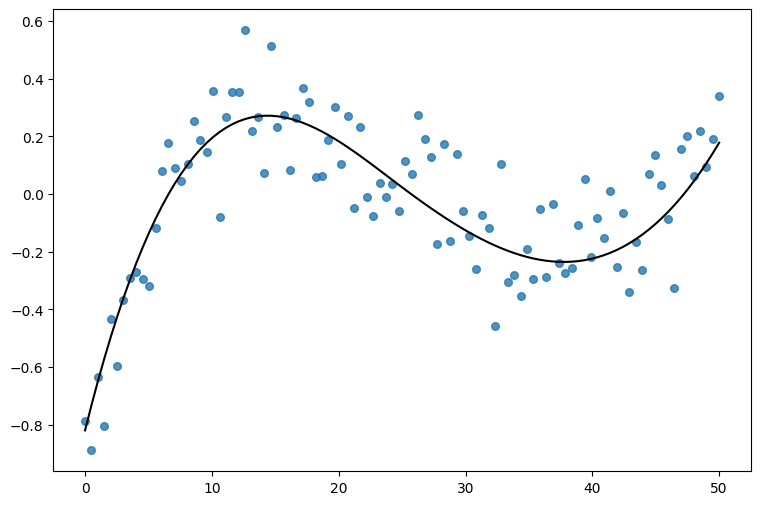

In [2]:
rng = np.random.default_rng(seed=121195)

N = 100
x = np.linspace(0, 50, N)
b = 0.1 * rng.normal(size=5)
sigma_t = 0.15

dm = design_matrices("0 + bs(x, df=5, intercept=True)", pd.DataFrame({"x": x}))
X = np.array(dm.common)
f = 10 * X @ b
y = f + sigma_t * rng.normal(size=N)

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x, y, s=30, alpha=0.8);
ax.plot(x, f, color="black");

In [3]:
g = ["g1", "g2"] * 50
df = pd.DataFrame({"x": x, "y": y, "g": g})
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2),
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1)
}
priors = {
    "hsgp(x, m=10, c=2, centered=True)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=10)
}
model = bmb.Model("y ~ 0 + hsgp(x, m=10, c=2, centered=True)", df, priors=priors)
model.set_alias({"hsgp(x, m=10, c=2, centered=True)": "hsgp"})

In [4]:
term = model.response_component.terms["hsgp(x, m=10, c=2, centered=True)"]
term

HSGPTerm(  
  name: hsgp(x, m=10, c=2, centered=True) (alias: hsgp),
  prior: {'sigma': Exponential(lam: 2.0), 'ell': InverseGamma(mu: 10.0, sigma: 1.0)},
  shape: (100, 1),
  categorical: False
)

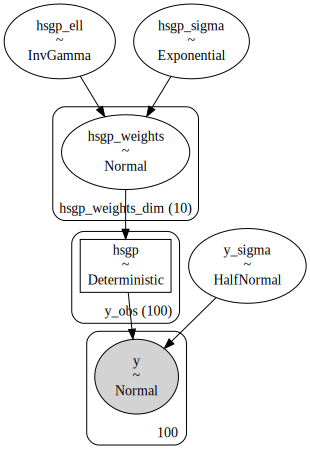

In [5]:
model.build()
model.graph()

In [6]:
idata = model.fit(inference_method="nuts_numpyro")

/home/tomas/anaconda3/envs/bambi_hsgp/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:03.224429
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.943759
Transforming variables...
Transformation time =  0:00:00.178443


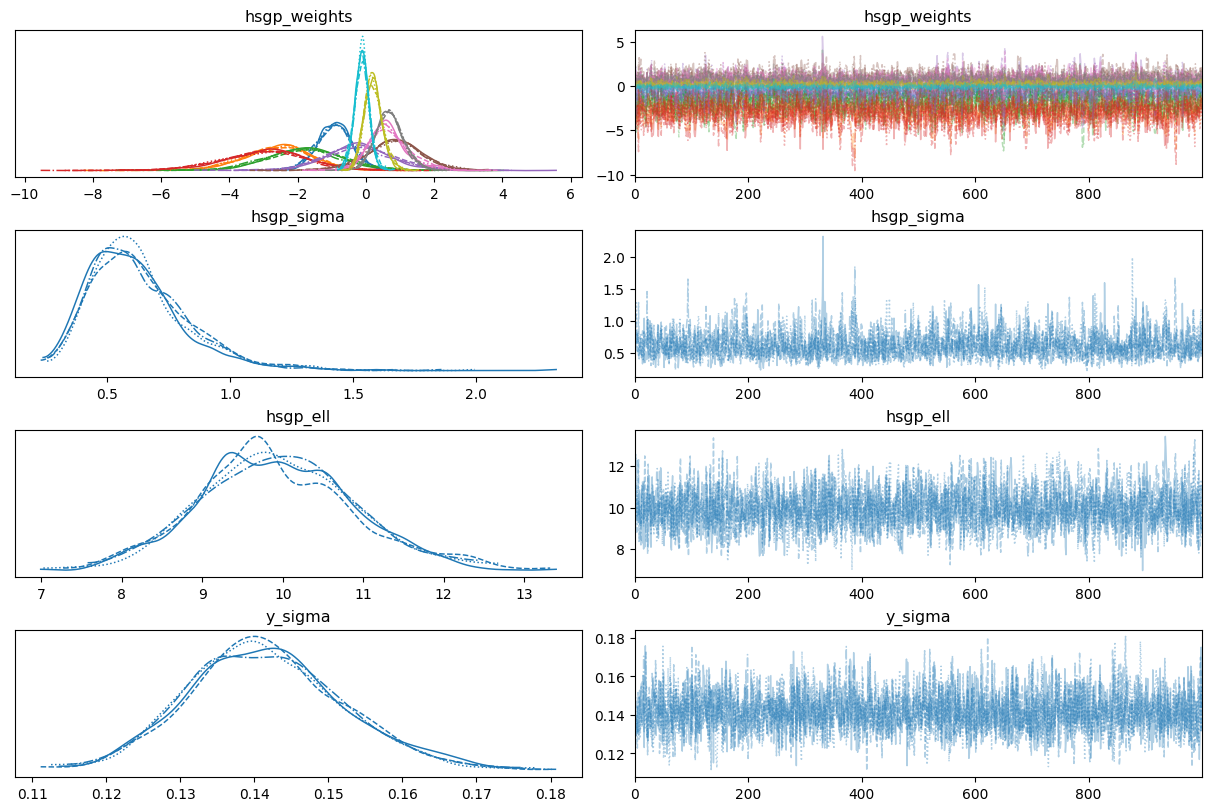

In [7]:
az.plot_trace(
    idata, 
    var_names=["hsgp_weights", "hsgp_sigma", "hsgp_ell", "y_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

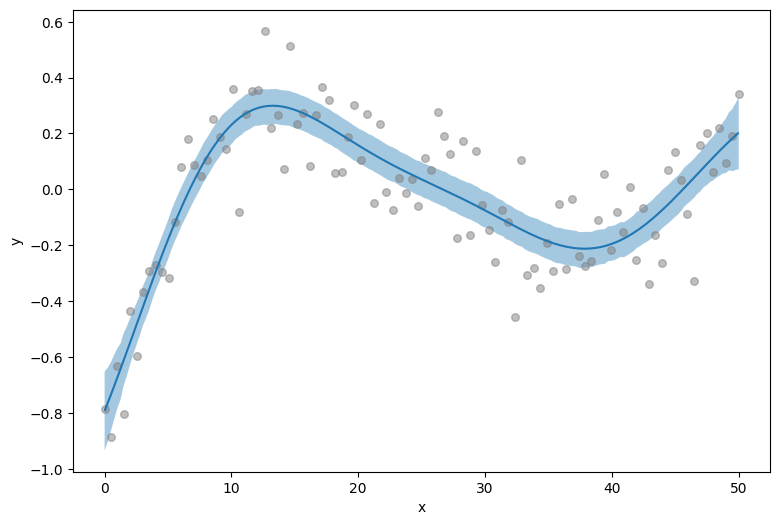

In [8]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_cap(model, idata, "x", ax=ax)
ax.scatter(df["x"], df["y"], s=30, color="0.5", alpha=0.5);

In [9]:
import pymc as pm

In [10]:
x_new = np.linspace(-10, 70, 500)
model.predict(idata, kind="pps", data=pd.DataFrame({"x": x_new}))
f_new = idata.posterior_predictive["y"].stack(sample=("chain", "draw")).T.to_numpy()

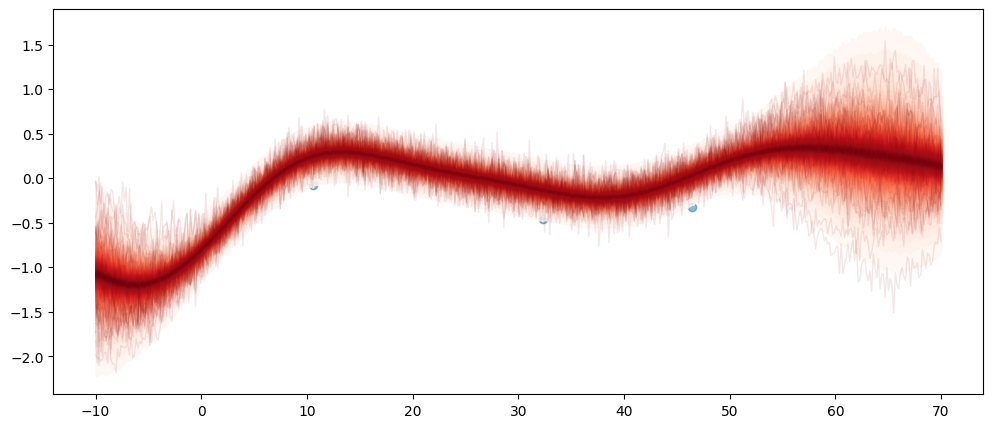

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.scatter(x, y, alpha=0.5);
pm.gp.util.plot_gp_dist(ax, f_new, x_new);

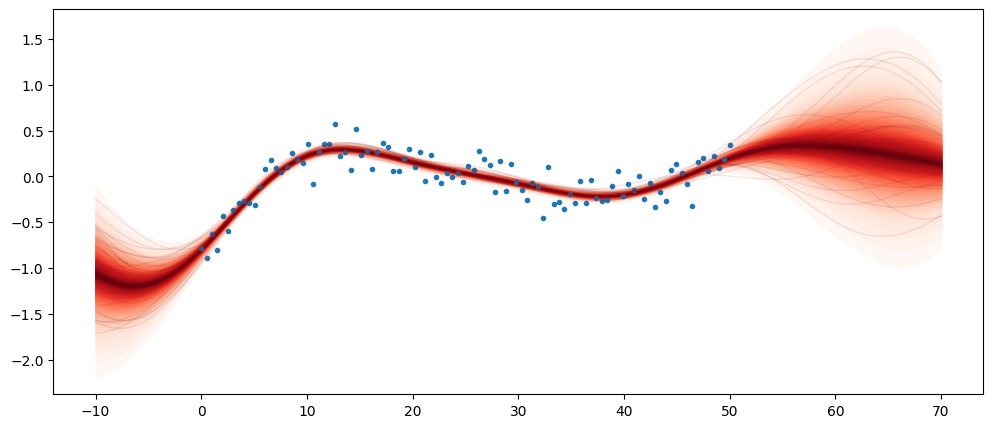

In [12]:
f_new = idata.posterior["hsgp"].stack(sample=("chain", "draw")).T.to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(x, y, '.')
pm.gp.util.plot_gp_dist(ax, f_new, x_new);

---

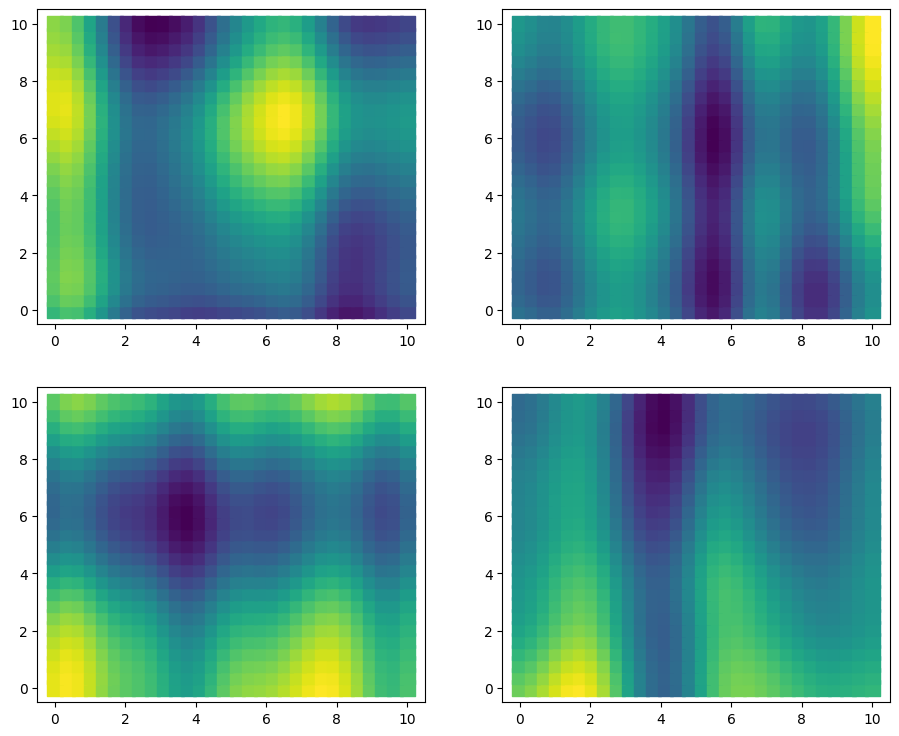

In [13]:
import pymc as pm
rng = np.random.default_rng(seed=1234)

# make X grid
x1 = np.linspace(0, 10, 30)
x2 = np.linspace(0, 10, 25)
xx, yy = np.meshgrid(x1, x2)
X = np.concatenate((yy.flatten()[:, None], xx.flatten()[:, None]), axis=1)

## row and range "factors"
ell_row = 2
cov_row = pm.gp.cov.ExpQuad(2, ls=ell_row, active_dims=[0])

ell_range = 1
cov_range = pm.gp.cov.ExpQuad(2, ls=ell_range, active_dims=[1])

## anisotropic
ell_anisotropic = [4, 2] # row and range lengthscales in product cov
cov_anisotropic = pm.gp.cov.ExpQuad(2, ls=ell_anisotropic)

cov = cov_row + cov_range + cov_anisotropic
K = cov(X).eval()

ff = rng.multivariate_normal(np.zeros(X.shape[0]), K, 4).T

fig, axs = plt.subplots(2, 2, figsize=(11, 9)); 
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.scatter(xx, yy, c=ff[:, i], s=120, marker="s")
    ax.grid(False) 

In [14]:
y = yy.flatten()
x = xx.flatten()
f = ff[:, 0]

df = pd.DataFrame({"x": x, "y": y, "f": f})
df.head()

,x,y,f
0,0.000000,0.0,2.783611
1,0.344828,0.0,3.131854
2,0.689655,0.0,3.055532
3,1.034483,0.0,2.536763
4,1.379310,0.0,1.749508


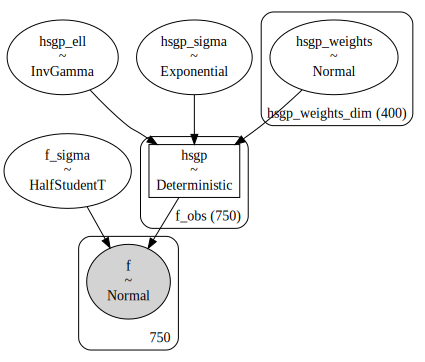

In [15]:
m = [20, 20]
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=1),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.5),
}
priors = {"hsgp(x, y, m=m, c=1.2)": prior_hsgp}
model = bmb.Model("f ~ 0 + hsgp(x, y, m=20, c=1.2)", df, priors=priors)
model.set_alias({"hsgp(x, y, m=20, c=1.2)": "hsgp"})
model.build()
model.graph()

In [16]:
idata = model.fit(inference_method="nuts_numpyro")

Compiling...
Compilation time =  0:00:17.134430
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:04:09.712710
Transforming variables...
Transformation time =  0:00:00.858182


In [17]:
az.summary(idata, var_names=["hsgp_sigma", "hsgp_ell"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hsgp_sigma,1.374,0.061,1.269,1.526,0.027,0.020,6.0,12.0,2.00
hsgp_ell,0.980,0.006,0.967,0.993,0.002,0.002,8.0,17.0,1.48


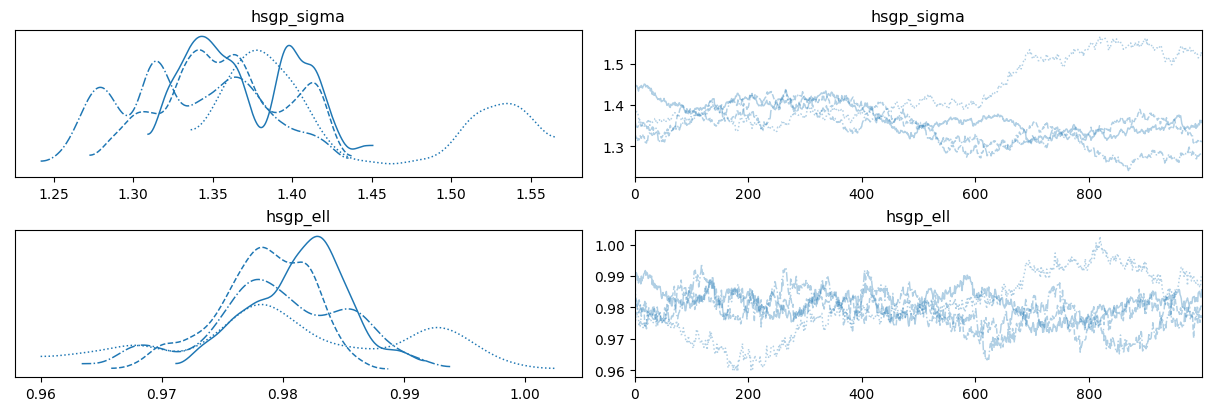

In [18]:
az.plot_trace(idata, var_names=["hsgp_sigma", "hsgp_ell"], backend_kwargs={"layout": "constrained"});

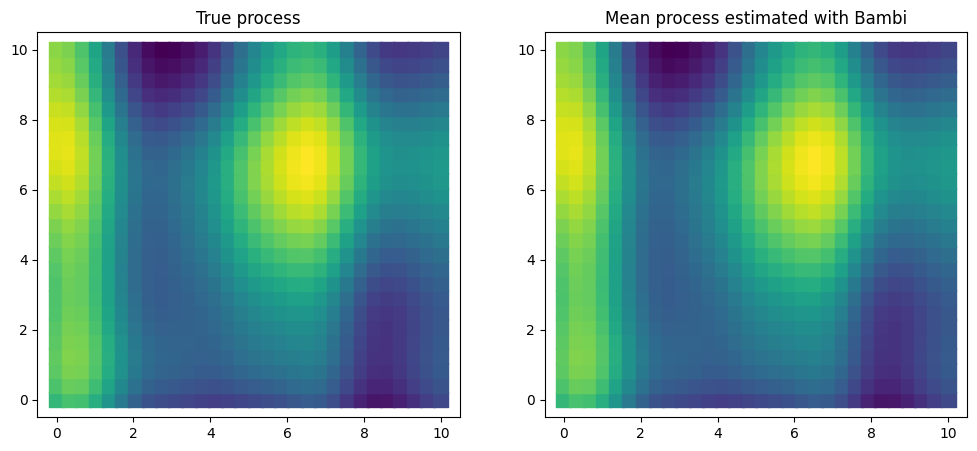

In [19]:
f_mean = idata.posterior["hsgp"].mean(("chain", "draw")).to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(xx, yy, c=ff[:, 0], s=120, marker="s")
axes[1].scatter(df["x"], df["y"], c=f_mean, s=120, marker="s")

axes[0].set_title("True process")
axes[1].set_title("Mean process estimated with Bambi")
axes[0].grid(False)
axes[1].grid(False)

## HSGP by levels of a categorical covariate

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#import pymc as pm
#import pymc.sampling_jax
#import pytensor.tensor as pt

In [2]:
data = pd.read_csv("gam_data.csv")
data.head()[["x2", "y", "fac"]]

,x2,y,fac
0,0.497183,3.085274,3
1,0.196003,-2.250410,2
2,0.958474,0.070548,3
3,0.972759,-0.230454,1
4,0.755836,2.173497,2


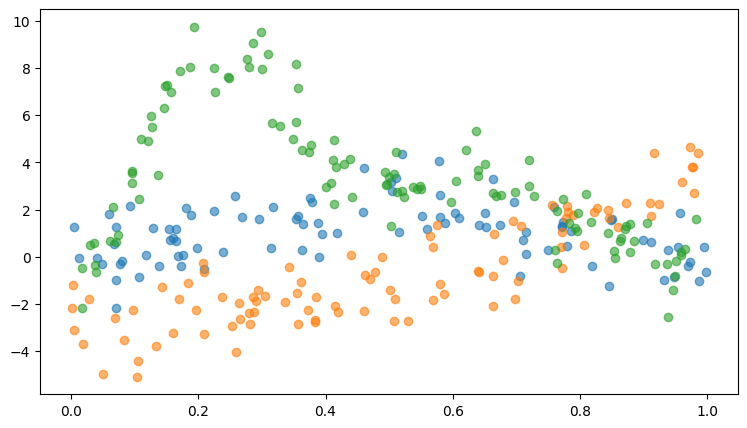

In [3]:
fig, ax = plt.subplots(figsize = (9, 5))

for i, (group, dat) in enumerate(data.groupby("fac")):
    ax.scatter(dat["x2"], dat["y"], color=f"C{i}", alpha=0.6)

In [8]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("Exponential", lam=3)
}
priors = {
    "hsgp(x2, by=fac, m=10, c=1.5, centered=False)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=1)
}
model = bmb.Model("y ~ 0 + hsgp(x2, by=fac, m=10, c=1.5, centered=False)", data, priors=priors)
model.set_alias({"hsgp(x2, by=fac, m=10, c=1.5, centered=False)": "hsgp"})

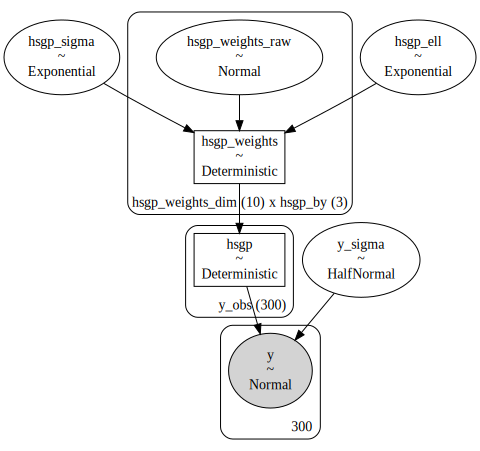

In [9]:
model.build()
model.graph()

In [10]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)

Compiling...
Compilation time =  0:00:03.806091
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.646647
Transforming variables...
Transformation time =  0:00:00.873591


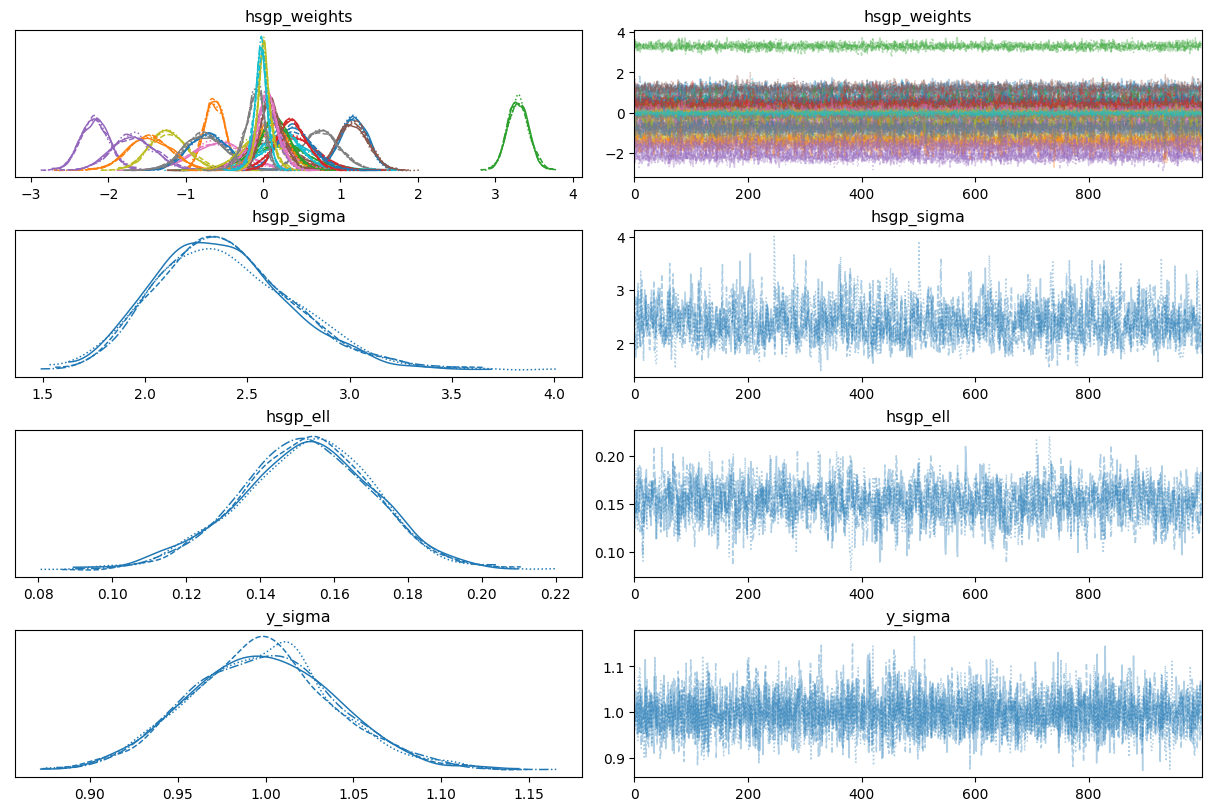

In [11]:
az.plot_trace(
    idata, 
    var_names=["hsgp_weights", "hsgp_sigma", "hsgp_ell", "y_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

In [16]:
hsgp_by, _ = np.unique(data["fac"], return_inverse=True)

coords = {
    "hsgp_by": hsgp_by,
    "hsgp_weight_dim": np.arange(10),
    "response_dim": np.arange(data.shape[0])
}

indexes_to_unsort = data["fac"].to_numpy().argsort(kind="mergesort").argsort(kind="mergesort")
with pm.Model(coords=coords) as model:
    eta = pm.Exponential("eta", lam=2.0)
    ell = pm.Exponential("ell", lam=3)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    hsgp = pm.gp.HSGP(m=[10], c=2, cov_func=cov)

    sqrt_psd_list = []
    phi_list = []

    for group, dat in data.groupby("fac"):
        phi, sqrt_psd = hsgp.prior_components(dat["x2"].to_numpy()[:, None])
        sqrt_psd_list.append(sqrt_psd)
        phi_list.append(phi)

    sqrt_psd = pt.stack(sqrt_psd_list, axis=1)
    beta = pm.Normal("hsgp_weights", sigma=sqrt_psd, dims=("hsgp_weight_dim", "hsgp_by"))

    contribution_list = []
    for i in range(3):
        contribution_list.append(phi_list[i] @ beta[:, i])
    
    contribution = pt.concatenate(contribution_list)
    f = pm.Deterministic("f", contribution[indexes_to_unsort], dims=("response_dim", ))

    sigma = pm.HalfNormal("sigma", sigma=1)
    pm.Normal("response", mu=f, sigma=sigma, observed=data["y"], dims=("response_dim", ))

AttributeError: 'HSGP' object has no attribute 'prior_components'

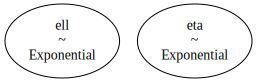

In [17]:
pm.model_to_graphviz(model)

In [18]:
with model:
        idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9)
print(idata.sample_stats.diverging.sum())

Compiling...
Compilation time =  0:00:01.359104
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:02.790496
Transforming variables...
Transformation time =  0:00:00.011267
<xarray.DataArray 'diverging' ()>
array(0)


KeyError: 'var names: "[\'f\'] are not present" in dataset'

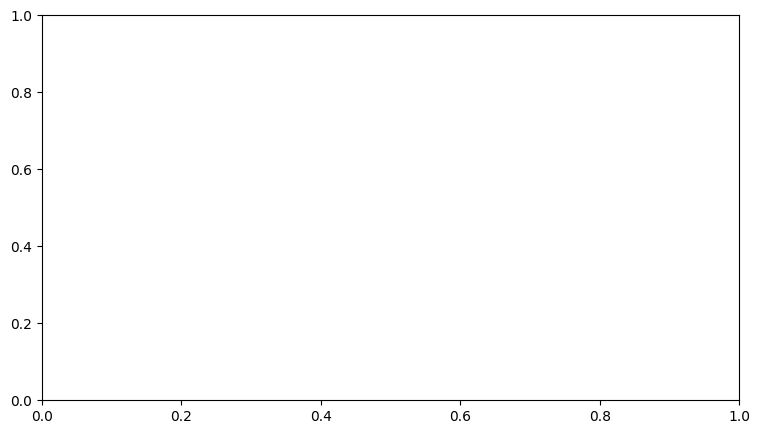

In [19]:
fig, ax = plt.subplots(figsize = (9, 5))
ff = az.extract(idata, "posterior", var_names=["f"]).to_numpy().T
for i, (group, dat) in enumerate(data.groupby("fac")):
    index = dat.index.to_numpy()
    index = index[np.argsort(dat["x2"]).to_numpy()]
    ax.scatter(dat["x2"], dat["y"], color=f"C{i}", alpha=0.6)
    pm.gp.util.plot_gp_dist(ax, ff[:, index], np.sort(dat["x2"].to_numpy()));

In [27]:
# https://stackoverflow.com/questions/42771850/how-to-sort-unsort-array1-sort-transform-of-array2-array3-unsort-reve/42773259#42773259
group = np.array(["C", "B", "B", "B", "C", "A", "A", "C", "A", "A", "B"])
print(group)
print(np.unique(group, return_inverse=True))
print(np.unique(group, return_counts=True))
indexes_to_unsort = group.argsort().argsort()
print(np.sort(group)[indexes_to_unsort])

['C' 'B' 'B' 'B' 'C' 'A' 'A' 'C' 'A' 'A' 'B']
(array(['A', 'B', 'C'], dtype='<U1'), array([2, 1, 1, 1, 2, 0, 0, 2, 0, 0, 1]))
(array(['A', 'B', 'C'], dtype='<U1'), array([4, 4, 3]))
['C' 'B' 'B' 'B' 'C' 'A' 'A' 'C' 'A' 'A' 'B']


---

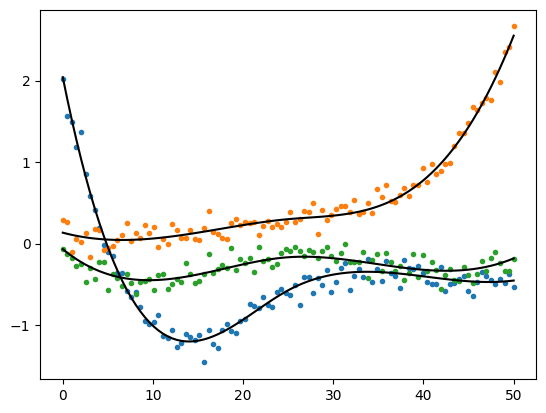

In [12]:
import patsy as pat
rng = np.random.default_rng(seed=3)

N = 100
x = np.linspace(0, 50, N)

df = 5
X = pat.dmatrix(f"bs(x, df={df}, degree=3, include_intercept=True) - 1", {"x": x})

Y, F = [], []
for i in range(3):
    b = 0.1 * rng.normal(size=df)
    f = 10 * X @ b
    sigma_t = 0.1
    y = f + sigma_t * rng.normal(size=len(x))
    
    F.append(f)
    Y.append(y)

F = np.vstack(F).T
Y = np.vstack(Y).T

plt.plot(x, Y, '.');
plt.plot(x, F, color="k");
X = x[:, None]

In [10]:
data = pd.DataFrame(
    {
        "y": Y.reshape(300, order="F"),
        "x": np.tile(x, 3),
        "group": np.repeat(list("ABC"), 100)
    }
)

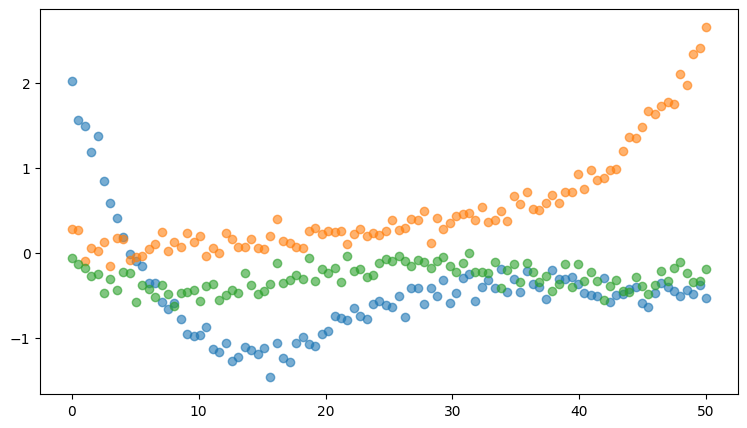

In [11]:
fig, ax = plt.subplots(figsize = (9, 5))

for i, (group, dat) in enumerate(data.groupby("group")):
    ax.scatter(dat["x"], dat["y"], color=f"C{i}", alpha=0.6)

In [12]:
coords = {
    "hsgp_by": list("ABC"),
    "hsgp_weight_dim": np.arange(10),
    "response_dim": np.arange(data.shape[0])
}

indexes_to_unsort = data["group"].to_numpy().argsort(kind="mergesort").argsort(kind="mergesort")
with pm.Model(coords=coords) as model:
    output = np.zeros(data.shape[0])
    eta = pm.Exponential("eta", lam=2.0)
    ell = pm.InverseGamma("ell", mu=10, sigma=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    hsgp = pm.gp.HSGP(m=[10], c=2, cov_func=cov)

    sqrt_psd_list = []
    phi_list = []

    for group, dat in data.groupby("group"):
        phi, sqrt_psd = hsgp.prior_components(dat["x"].to_numpy()[:, None])
        sqrt_psd_list.append(sqrt_psd)
        phi_list.append(phi)

    sqrt_psd = pt.stack(sqrt_psd_list, axis=1)
    beta = pm.Normal("hsgp_weights", sigma=sqrt_psd, dims=("hsgp_weight_dim", "hsgp_by"))

    contribution_list = []
    for i in range(3):
        contribution_list.append(phi_list[i] @ beta[:, i])
    
    contribution = pt.concatenate(contribution_list)
    f = pm.Deterministic("f", contribution[indexes_to_unsort], dims=("response_dim", ))

    sigma = pm.HalfNormal("sigma", sigma=1)
    pm.Normal("response", mu=f, sigma=sigma, observed=data["y"], dims=("response_dim", ))

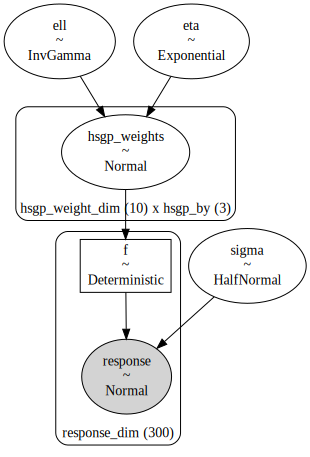

In [13]:
pm.model_to_graphviz(model)

In [14]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(8)
print(idata.sample_stats.diverging.sum())

Compiling...
Compilation time =  0:00:04.277266
Sampling...


  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/1008 [00:00<?, ?it/s]

Sampling time =  0:00:13.459812
Transforming variables...
Transformation time =  0:00:00.425004
<xarray.DataArray 'diverging' ()>
array(0)


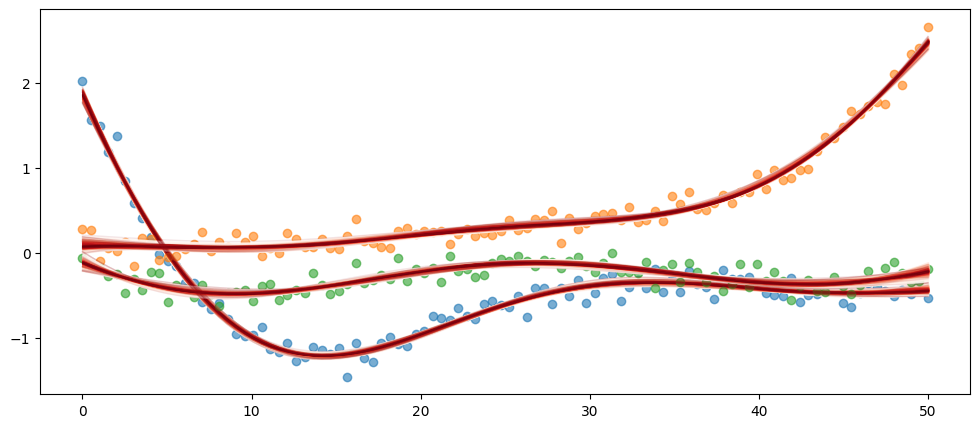

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ff = az.extract(idata, "posterior", var_names=["f"]).to_numpy().T

for i, (group, dat) in enumerate(data.groupby("group")):
    index = dat.index.to_numpy()
    ax.scatter(dat["x"], dat["y"], color=f"C{i}", alpha=0.6)
    pm.gp.util.plot_gp_dist(ax, ff[:, index], dat["x"].to_numpy());

What if we shuffle the rows?

,y,x,group
0,-0.472275,8.585859,C
1,-0.096662,1.010101,B
2,-0.373323,45.959596,C
3,-0.157502,26.767677,C
4,-0.463150,43.939394,C


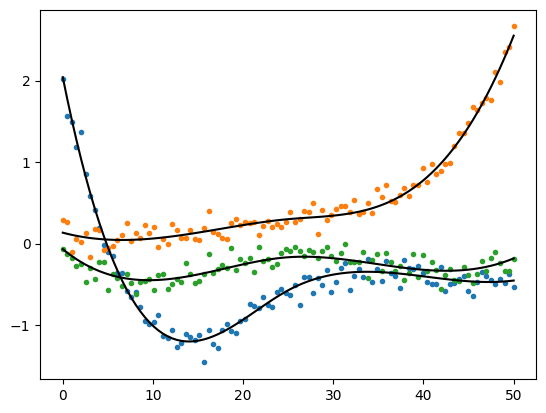

In [20]:
import patsy as pat
rng = np.random.default_rng(seed=3)

N = 100
x = np.linspace(0, 50, N)

df = 5
X = pat.dmatrix(f"bs(x, df={df}, degree=3, include_intercept=True) - 1", {"x": x})

Y, F = [], []
for i in range(3):
    b = 0.1 * rng.normal(size=df)
    f = 10 * X @ b
    sigma_t = 0.1
    y = f + sigma_t * rng.normal(size=len(x))
    
    F.append(f)
    Y.append(y)

F = np.vstack(F).T
Y = np.vstack(Y).T

plt.plot(x, Y, '.');
plt.plot(x, F, color="k");
X = x[:, None]


data = pd.DataFrame(
    {
        "y": Y.reshape(300, order="F"),
        "x": np.tile(x, 3),
        "group": np.repeat(list("ABC"), 100)
    }
)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

The viz is still the same...

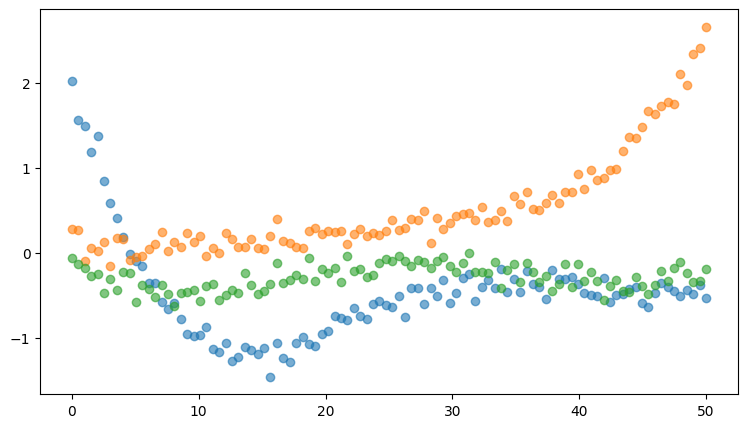

In [21]:
fig, ax = plt.subplots(figsize = (9, 5))

for i, (group, dat) in enumerate(data.groupby("group")):
    ax.scatter(dat["x"], dat["y"], color=f"C{i}", alpha=0.6)

In [22]:
coords = {
    "hsgp_by": list("ABC"),
    "hsgp_weight_dim": np.arange(10),
    "response_dim": np.arange(data.shape[0])
}

indexes_to_unsort = data["group"].to_numpy().argsort(kind="mergesort").argsort(kind="mergesort")
with pm.Model(coords=coords) as model:
    eta = pm.Exponential("eta", lam=2.0)
    ell = pm.InverseGamma("ell", mu=10, sigma=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    hsgp = pm.gp.HSGP(m=[10], c=2, cov_func=cov)

    sqrt_psd_list = []
    phi_list = []

    for group, dat in data.groupby("group"):
        phi, sqrt_psd = hsgp.prior_components(dat["x"].to_numpy()[:, None])
        sqrt_psd_list.append(sqrt_psd)
        phi_list.append(phi)

    sqrt_psd = pt.stack(sqrt_psd_list, axis=1)
    beta = pm.Normal("hsgp_weights", sigma=sqrt_psd, dims=("hsgp_weight_dim", "hsgp_by"))

    contribution_list = []
    for i in range(3):
        contribution_list.append(phi_list[i] @ beta[:, i])
    
    contribution = pt.concatenate(contribution_list)
    f = pm.Deterministic("f", contribution[indexes_to_unsort], dims=("response_dim", ))

    sigma = pm.HalfNormal("sigma", sigma=1)
    pm.Normal("response", mu=f, sigma=sigma, observed=data["y"], dims=("response_dim", ))

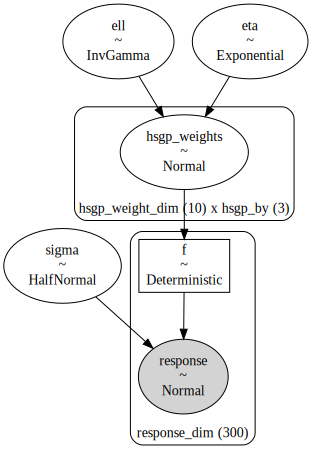

In [23]:
pm.model_to_graphviz(model)

In [24]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(8)
print(idata.sample_stats.diverging.sum())

Compiling...
Compilation time =  0:00:06.696413
Sampling...


  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/1008 [00:00<?, ?it/s]

Sampling time =  0:00:14.932644
Transforming variables...
Transformation time =  0:00:00.492488
<xarray.DataArray 'diverging' ()>
array(0)


In [25]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"hsgp_weights[0, A]",15.939,7.388,3.208,30.312,1.064,0.757,48.0,48.0,1.00
"hsgp_weights[0, B]",7.216,5.577,-2.324,17.183,0.804,0.572,48.0,48.0,1.02
"hsgp_weights[0, C]",2.118,5.985,-11.690,9.074,0.862,0.613,48.0,48.0,1.22
"hsgp_weights[1, A]",15.470,11.572,-1.612,37.024,1.667,1.186,48.0,48.0,1.02
"hsgp_weights[1, B]",-15.446,7.103,-26.776,-0.664,1.023,0.728,48.0,48.0,1.01
...,...,...,...,...,...,...,...,...,...
f[295],-0.461,0.020,-0.491,-0.421,0.003,0.002,48.0,48.0,1.14
f[296],0.094,0.028,0.052,0.145,0.004,0.003,48.0,48.0,0.93
f[297],1.143,0.025,1.089,1.184,0.004,0.003,48.0,48.0,1.09
f[298],-0.969,0.023,-1.017,-0.932,0.003,0.002,48.0,48.0,1.01


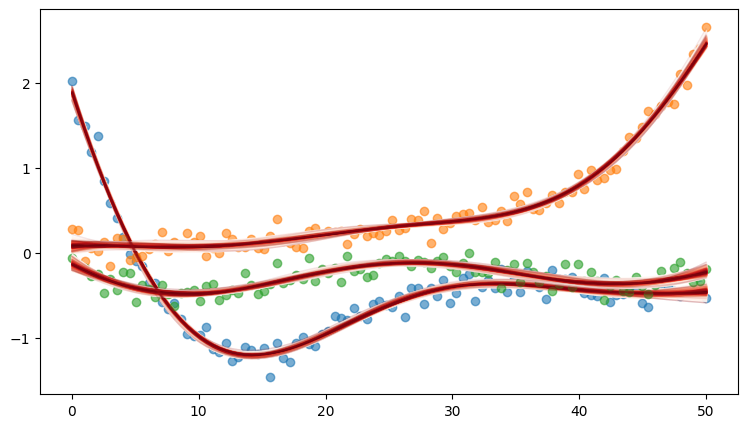

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ff = az.extract(idata, "posterior", var_names=["f"]).to_numpy().T

for i, (group, dat) in enumerate(data.groupby("group")):
    index = dat.index.to_numpy()
    index = index[np.argsort(dat["x"]).to_numpy()]
    ax.scatter(dat["x"], dat["y"], color=f"C{i}", alpha=0.6)
    pm.gp.util.plot_gp_dist(ax, ff[:, index], np.sort(dat["x"].to_numpy()));

1. We always have to pass 'L' so we don't face the warning in `pymc.gp.HSGP` due to predictions.
    * The transformation has to accept both 'c' and 'L', and check that only one is passed.
    * Then internally we always transform to 'L'
1. We always have to subtract the mean so the values are centered around 0.
    * We have to keep the original mean, so any other values are centered the same way.
1. Allow to pass `m` and `L` without being a list, use listify() internally.